<a href="https://colab.research.google.com/github/PetitYohan/DataMining/blob/main/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet de DataMining
Par Catherine Vanden Hende & Yohan Petit

##Initialisation du Projet

In [2]:
! pip install kaggle
! rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d razinw/dog-vs-cat
! rm -r images
! mkdir images
! unzip dog-vs-cat.zip -d images/

 97% 402M/412M [00:02<00:00, 209MB/s]
100% 412M/412M [00:02<00:00, 189MB/s]
Archive:  dog-vs-cat.zip
  inflating: images/dogvscat/test/0/250.jpg  
  inflating: images/dogvscat/test/0/251.jpg  
  inflating: images/dogvscat/test/0/252.jpg  
  inflating: images/dogvscat/test/0/253.jpg  
  inflating: images/dogvscat/test/0/254.jpg  
  inflating: images/dogvscat/test/0/255.jpg  
  inflating: images/dogvscat/test/0/256.jpg  
  inflating: images/dogvscat/test/0/257.jpg  
  inflating: images/dogvscat/test/0/258.jpg  
  inflating: images/dogvscat/test/0/259.jpg  
  inflating: images/dogvscat/test/0/260.jpg  
  inflating: images/dogvscat/test/0/261.jpg  
  inflating: images/dogvscat/test/0/262.jpg  
  inflating: images/dogvscat/test/0/263.jpg  
  inflating: images/dogvscat/test/0/264.jpg  
  inflating: images/dogvscat/test/0/265.jpg  
  inflating: images/dogvscat/test/0/266.jpg  
  inflating: images/dogvscat/test/0/267.jpg  
  inflating: images/dogvscat/test/0/268.jpg  
  inflating: images/dogvs

##Récupération des métadonnées dans des json

In [3]:
!pip3 install Pillow
!mkdir metadata
!mkdir metadata/train
!mkdir metadata/train/0
!mkdir metadata/train/1

from PIL import Image
from PIL.ExifTags import TAGS
import os
import json

# path to the directory
path0 = "images/dogvscat/train/0"
path1 = "images/dogvscat/train/1"

def exportMetadata(path):
  # directory
  directory = os.listdir(path)
  metadata = []
  photo = dict()

  for files in directory:
    if files.endswith ('.jpg'):
      # find file path
      file_path = os.path.join(path,files)
      # read the image data using PIL
      image = Image.open(file_path)
      # extract EXIF data
      exifdata = image.getexif()
      # iterating over all EXIF data fields
      for tag_id in exifdata:
          # get the tag name, instead of human unreadable tag id
          tag = TAGS.get(tag_id, tag_id)
          data = exifdata.get(tag_id)
          # decode bytes 
          if isinstance(data, bytes):
              data = data.decode()
          if tag != 'GPSInfo':
            photo[tag]=data
      # metadata list for each photo
      metadata.append(photo)
      photo = {}
  return metadata

# create json file
with open("metadata/train/0/metadata.json", "w") as file:
    json.dump(exportMetadata(path0), file, separators=(',', ':'), indent=4)
with open("metadata/train/1/metadata.json", "w") as file:
    json.dump(exportMetadata(path1), file, separators=(',', ':'), indent=4)

##Étiquetage et annotation

Image n°0
#cecdbe
#1f1e1d
#777a77


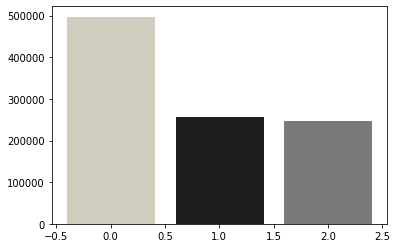

Image n°1
#141415
#c6c1ba
#515558


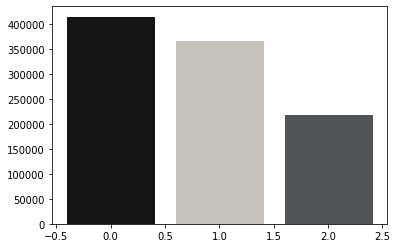

Image n°2
#cbcfd0
#2c1f16
#7a5c4c


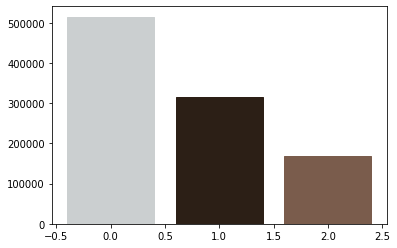

In [7]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
!pip3 install webcolors
import webcolors

def hex_to_rgb(hex):
  hex = hex.split("#")[1]
  rgb = []
  for i in (0, 2, 4):
    decimal = int(hex[i:i+2], 16)
    rgb.append(decimal)
  return tuple(rgb)

def get_color_name(various):
  peak = hex_to_rgb(various)
  try:
    closest_name = actual_name = webcolors.hex_to_name(various)
  except ValueError:
    closest_name = various
    actual_name = None
  return closest_name

for j in range(3):
  imgfile = Image.open("images/dogvscat/train/0/"+str(j)+".jpg")
  numarray = numpy.array(imgfile.getdata(), numpy.uint8)
  clusters = KMeans(n_clusters=3)
  clusters.fit(numarray)
  npbins = numpy.arange(0, 4)
  histogram = numpy.histogram(clusters.labels_, bins=npbins)
  labels = numpy.unique(clusters.labels_)
  barlist = plot.bar(labels, sorted(histogram[0], reverse=True))
  colors=[]
  print("Image n°"+str(j))
  for i in range(3):
    barlist[i].set_color("#%02x%02x%02x" % (
      math.ceil(clusters.cluster_centers_[i][0]),
      math.ceil(clusters.cluster_centers_[i][1]),
      math.ceil(clusters.cluster_centers_[i][2]),
      )
    )
    colors.append('#%02x%02x%02x' % (
      math.ceil(clusters.cluster_centers_[i][0]),
      math.ceil(clusters.cluster_centers_[i][1]),
      math.ceil(clusters.cluster_centers_[i][2]),
      )
    )
    print(get_color_name(colors[i]))
  plot.show()